In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "flow_vcr_mse"
ood = "0"

In [3]:
# Parameters
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                        | 0/60000 [00:00<?, ?it/s]

 10%|█████████▏                                                                                | 6124/60000 [00:00<00:00, 61232.32it/s]

 21%|███████████████████                                                                      | 12854/60000 [00:00<00:00, 64798.67it/s]

 33%|█████████████████████████████                                                            | 19568/60000 [00:00<00:00, 65863.73it/s]

 44%|███████████████████████████████████████                                                  | 26344/60000 [00:00<00:00, 66608.19it/s]

 55%|█████████████████████████████████████████████████                                        | 33077/60000 [00:00<00:00, 66868.08it/s]

 66%|███████████████████████████████████████████████████████████                              | 39828/60000 [00:00<00:00, 67085.36it/s]

 78%|█████████████████████████████████████████████████████████████████████                    | 46537/60000 [00:00<00:00, 66972.79it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▏         | 53350/60000 [00:00<00:00, 67340.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 66666.61it/s]

  0%|                                                                                                        | 0/10000 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 6753/10000 [00:00<00:00, 67528.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 66240.11it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
model_ids = {
    "0:1:2:3:4": '59ftut3f',
    "5:6:7:8:9": "lz2g3fq1",
    "0": "cpnxtpv2",
    "1": "c6sohudf",
    "2": "5qeniujh",
    "3": "cto6ipr0",
}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

5:6:7:8:9 lz2g3fq1


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                          | 0/383 [00:00<?, ?it/s]

  0%|▎                                                                                                 | 1/383 [00:00<04:46,  1.33it/s]

  1%|█                                                                                                 | 4/383 [00:00<01:04,  5.86it/s]

  2%|██                                                                                                | 8/383 [00:00<00:31, 11.73it/s]

  3%|███                                                                                              | 12/383 [00:01<00:22, 16.85it/s]

  4%|████                                                                                             | 16/383 [00:01<00:17, 21.16it/s]

  5%|█████                                                                                            | 20/383 [00:01<00:14, 24.63it/s]

  6%|██████                                                                                           | 24/383 [00:01<00:13, 27.32it/s]

  7%|███████                                                                                          | 28/383 [00:01<00:12, 28.89it/s]

  8%|████████                                                                                         | 32/383 [00:01<00:11, 30.56it/s]

  9%|█████████                                                                                        | 36/383 [00:01<00:10, 31.73it/s]

 10%|██████████▏                                                                                      | 40/383 [00:01<00:10, 32.54it/s]

 11%|███████████▏                                                                                     | 44/383 [00:02<00:10, 33.15it/s]

 13%|████████████▏                                                                                    | 48/383 [00:02<00:09, 33.75it/s]

 14%|█████████████▏                                                                                   | 52/383 [00:02<00:09, 34.13it/s]

 15%|██████████████▏                                                                                  | 56/383 [00:02<00:09, 34.30it/s]

 16%|███████████████▏                                                                                 | 60/383 [00:02<00:09, 34.35it/s]

 17%|████████████████▏                                                                                | 64/383 [00:02<00:09, 34.54it/s]

 18%|█████████████████▏                                                                               | 68/383 [00:02<00:09, 34.77it/s]

 19%|██████████████████▏                                                                              | 72/383 [00:02<00:08, 34.89it/s]

 20%|███████████████████▏                                                                             | 76/383 [00:02<00:08, 35.02it/s]

 21%|████████████████████▎                                                                            | 80/383 [00:03<00:08, 35.04it/s]

 22%|█████████████████████▎                                                                           | 84/383 [00:03<00:08, 35.05it/s]

 23%|██████████████████████▎                                                                          | 88/383 [00:03<00:08, 35.06it/s]

 24%|███████████████████████▎                                                                         | 92/383 [00:03<00:08, 34.90it/s]

 25%|████████████████████████▎                                                                        | 96/383 [00:03<00:08, 34.83it/s]

 26%|█████████████████████████                                                                       | 100/383 [00:03<00:08, 34.47it/s]

 27%|██████████████████████████                                                                      | 104/383 [00:03<00:08, 34.44it/s]

 28%|███████████████████████████                                                                     | 108/383 [00:03<00:07, 34.41it/s]

 29%|████████████████████████████                                                                    | 112/383 [00:03<00:07, 34.47it/s]

 30%|█████████████████████████████                                                                   | 116/383 [00:04<00:07, 34.34it/s]

 31%|██████████████████████████████                                                                  | 120/383 [00:04<00:07, 34.34it/s]

 32%|███████████████████████████████                                                                 | 124/383 [00:04<00:07, 34.18it/s]

 33%|████████████████████████████████                                                                | 128/383 [00:04<00:07, 33.97it/s]

 34%|█████████████████████████████████                                                               | 132/383 [00:04<00:07, 34.29it/s]

 36%|██████████████████████████████████                                                              | 136/383 [00:04<00:07, 34.49it/s]

 37%|███████████████████████████████████                                                             | 140/383 [00:04<00:07, 34.70it/s]

 38%|████████████████████████████████████                                                            | 144/383 [00:04<00:06, 34.94it/s]

 39%|█████████████████████████████████████                                                           | 148/383 [00:05<00:06, 35.09it/s]

 40%|██████████████████████████████████████                                                          | 152/383 [00:05<00:06, 35.09it/s]

 41%|███████████████████████████████████████                                                         | 156/383 [00:05<00:06, 35.10it/s]

 42%|████████████████████████████████████████                                                        | 160/383 [00:05<00:06, 35.15it/s]

 43%|█████████████████████████████████████████                                                       | 164/383 [00:05<00:06, 35.25it/s]

 44%|██████████████████████████████████████████                                                      | 168/383 [00:05<00:06, 35.16it/s]

 45%|███████████████████████████████████████████                                                     | 172/383 [00:05<00:05, 35.18it/s]

 46%|████████████████████████████████████████████                                                    | 176/383 [00:05<00:05, 35.23it/s]

 47%|█████████████████████████████████████████████                                                   | 180/383 [00:05<00:05, 35.21it/s]

 48%|██████████████████████████████████████████████                                                  | 184/383 [00:06<00:05, 35.18it/s]

 49%|███████████████████████████████████████████████                                                 | 188/383 [00:06<00:05, 35.17it/s]

 50%|████████████████████████████████████████████████▏                                               | 192/383 [00:06<00:05, 34.88it/s]

 51%|█████████████████████████████████████████████████▏                                              | 196/383 [00:06<00:05, 34.81it/s]

 52%|██████████████████████████████████████████████████▏                                             | 200/383 [00:06<00:05, 34.69it/s]

 53%|███████████████████████████████████████████████████▏                                            | 204/383 [00:06<00:05, 34.71it/s]

 54%|████████████████████████████████████████████████████▏                                           | 208/383 [00:06<00:05, 34.79it/s]

 55%|█████████████████████████████████████████████████████▏                                          | 212/383 [00:06<00:04, 34.92it/s]

 56%|██████████████████████████████████████████████████████▏                                         | 216/383 [00:06<00:04, 35.01it/s]

 57%|███████████████████████████████████████████████████████▏                                        | 220/383 [00:07<00:04, 35.03it/s]

 58%|████████████████████████████████████████████████████████▏                                       | 224/383 [00:07<00:04, 34.87it/s]

 60%|█████████████████████████████████████████████████████████▏                                      | 228/383 [00:07<00:04, 34.86it/s]

 61%|██████████████████████████████████████████████████████████▏                                     | 232/383 [00:07<00:04, 34.79it/s]

 62%|███████████████████████████████████████████████████████████▏                                    | 236/383 [00:07<00:04, 34.85it/s]

 63%|████████████████████████████████████████████████████████████▏                                   | 240/383 [00:07<00:04, 34.89it/s]

 64%|█████████████████████████████████████████████████████████████▏                                  | 244/383 [00:07<00:03, 34.84it/s]

 65%|██████████████████████████████████████████████████████████████▏                                 | 248/383 [00:07<00:03, 34.87it/s]

 66%|███████████████████████████████████████████████████████████████▏                                | 252/383 [00:07<00:03, 34.85it/s]

 67%|████████████████████████████████████████████████████████████████▏                               | 256/383 [00:08<00:03, 34.85it/s]

 68%|█████████████████████████████████████████████████████████████████▏                              | 260/383 [00:08<00:03, 34.90it/s]

 69%|██████████████████████████████████████████████████████████████████▏                             | 264/383 [00:08<00:03, 34.89it/s]

 70%|███████████████████████████████████████████████████████████████████▏                            | 268/383 [00:08<00:03, 34.94it/s]

 71%|████████████████████████████████████████████████████████████████████▏                           | 272/383 [00:08<00:03, 34.98it/s]

 72%|█████████████████████████████████████████████████████████████████████▏                          | 276/383 [00:08<00:03, 34.91it/s]

 73%|██████████████████████████████████████████████████████████████████████▏                         | 280/383 [00:08<00:02, 34.97it/s]

 74%|███████████████████████████████████████████████████████████████████████▏                        | 284/383 [00:08<00:02, 35.00it/s]

 75%|████████████████████████████████████████████████████████████████████████▏                       | 288/383 [00:09<00:02, 35.00it/s]

 76%|█████████████████████████████████████████████████████████████████████████▏                      | 292/383 [00:09<00:02, 35.02it/s]

 77%|██████████████████████████████████████████████████████████████████████████▏                     | 296/383 [00:09<00:02, 35.04it/s]

 78%|███████████████████████████████████████████████████████████████████████████▏                    | 300/383 [00:09<00:02, 35.05it/s]

 79%|████████████████████████████████████████████████████████████████████████████▏                   | 304/383 [00:09<00:02, 35.03it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▏                  | 308/383 [00:09<00:02, 34.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▏                 | 312/383 [00:09<00:02, 34.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▏                | 316/383 [00:09<00:01, 34.58it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▏               | 320/383 [00:09<00:01, 34.60it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▏              | 324/383 [00:10<00:01, 34.74it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▏             | 328/383 [00:10<00:01, 34.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▏            | 332/383 [00:10<00:01, 34.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▏           | 336/383 [00:10<00:01, 34.75it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▏          | 340/383 [00:10<00:01, 34.66it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▏         | 344/383 [00:10<00:01, 34.77it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▏        | 348/383 [00:10<00:01, 34.82it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▏       | 352/383 [00:10<00:00, 34.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▏      | 356/383 [00:10<00:00, 34.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▏     | 360/383 [00:11<00:00, 34.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████▏    | 364/383 [00:11<00:00, 34.80it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 368/383 [00:11<00:00, 34.72it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▏  | 372/383 [00:11<00:00, 34.72it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▏ | 376/383 [00:11<00:00, 34.94it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████▏| 380/383 [00:11<00:00, 35.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 383/383 [00:11<00:00, 32.41it/s]

train - OK


  0%|                                                                                                           | 0/96 [00:00<?, ?it/s]

  1%|█                                                                                                  | 1/96 [00:00<00:13,  6.80it/s]

  5%|█████▏                                                                                             | 5/96 [00:00<00:04, 21.08it/s]

  9%|█████████▎                                                                                         | 9/96 [00:00<00:03, 26.77it/s]

 14%|█████████████▎                                                                                    | 13/96 [00:00<00:02, 29.74it/s]

 18%|█████████████████▎                                                                                | 17/96 [00:00<00:02, 31.46it/s]

 22%|█████████████████████▍                                                                            | 21/96 [00:00<00:02, 32.54it/s]

 26%|█████████████████████████▌                                                                        | 25/96 [00:00<00:02, 33.05it/s]

 30%|█████████████████████████████▌                                                                    | 29/96 [00:00<00:02, 33.48it/s]

 34%|█████████████████████████████████▋                                                                | 33/96 [00:01<00:01, 33.84it/s]

 39%|█████████████████████████████████████▊                                                            | 37/96 [00:01<00:01, 34.18it/s]

 43%|█████████████████████████████████████████▊                                                        | 41/96 [00:01<00:01, 34.34it/s]

 47%|█████████████████████████████████████████████▉                                                    | 45/96 [00:01<00:01, 34.50it/s]

 51%|██████████████████████████████████████████████████                                                | 49/96 [00:01<00:01, 34.55it/s]

 55%|██████████████████████████████████████████████████████                                            | 53/96 [00:01<00:01, 34.51it/s]

 59%|██████████████████████████████████████████████████████████▏                                       | 57/96 [00:01<00:01, 34.42it/s]

 64%|██████████████████████████████████████████████████████████████▎                                   | 61/96 [00:01<00:01, 34.42it/s]

 68%|██████████████████████████████████████████████████████████████████▎                               | 65/96 [00:02<00:00, 34.39it/s]

 72%|██████████████████████████████████████████████████████████████████████▍                           | 69/96 [00:02<00:00, 34.41it/s]

 76%|██████████████████████████████████████████████████████████████████████████▌                       | 73/96 [00:02<00:00, 34.51it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▌                   | 77/96 [00:02<00:00, 34.62it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▋               | 81/96 [00:02<00:00, 34.63it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 85/96 [00:02<00:00, 34.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 89/96 [00:02<00:00, 34.59it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 93/96 [00:02<00:00, 35.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 32.64it/s]

val - OK


  0%|                                                                                                           | 0/81 [00:00<?, ?it/s]

  1%|█▏                                                                                                 | 1/81 [00:00<00:11,  7.11it/s]

  6%|██████                                                                                             | 5/81 [00:00<00:03, 21.57it/s]

 11%|███████████                                                                                        | 9/81 [00:00<00:02, 27.12it/s]

 16%|███████████████▋                                                                                  | 13/81 [00:00<00:02, 29.93it/s]

 21%|████████████████████▌                                                                             | 17/81 [00:00<00:02, 31.45it/s]

 26%|█████████████████████████▍                                                                        | 21/81 [00:00<00:01, 32.43it/s]

 31%|██████████████████████████████▏                                                                   | 25/81 [00:00<00:01, 32.99it/s]

 36%|███████████████████████████████████                                                               | 29/81 [00:00<00:01, 33.36it/s]

 41%|███████████████████████████████████████▉                                                          | 33/81 [00:01<00:01, 33.54it/s]

 46%|████████████████████████████████████████████▊                                                     | 37/81 [00:01<00:01, 33.72it/s]

 51%|█████████████████████████████████████████████████▌                                                | 41/81 [00:01<00:01, 33.97it/s]

 56%|██████████████████████████████████████████████████████▍                                           | 45/81 [00:01<00:01, 34.17it/s]

 60%|███████████████████████████████████████████████████████████▎                                      | 49/81 [00:01<00:00, 34.18it/s]

 65%|████████████████████████████████████████████████████████████████                                  | 53/81 [00:01<00:00, 34.36it/s]

 70%|████████████████████████████████████████████████████████████████████▉                             | 57/81 [00:01<00:00, 34.38it/s]

 75%|█████████████████████████████████████████████████████████████████████████▊                        | 61/81 [00:01<00:00, 33.69it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▋                   | 65/81 [00:02<00:00, 33.83it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▍              | 69/81 [00:02<00:00, 34.05it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 73/81 [00:02<00:00, 34.15it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 77/81 [00:02<00:00, 35.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 33.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 32.15it/s]

test InD - OK


  0%|                                                                                                          | 0/536 [00:00<?, ?it/s]

  0%|▏                                                                                                 | 1/536 [00:00<01:14,  7.18it/s]

  1%|▉                                                                                                 | 5/536 [00:00<00:24, 21.63it/s]

  2%|█▋                                                                                                | 9/536 [00:00<00:19, 27.07it/s]

  2%|██▎                                                                                              | 13/536 [00:00<00:17, 29.87it/s]

  3%|███                                                                                              | 17/536 [00:00<00:16, 31.41it/s]

  4%|███▊                                                                                             | 21/536 [00:00<00:15, 32.45it/s]

  5%|████▌                                                                                            | 25/536 [00:00<00:15, 33.01it/s]

  5%|█████▏                                                                                           | 29/536 [00:00<00:15, 33.40it/s]

  6%|█████▉                                                                                           | 33/536 [00:01<00:14, 33.70it/s]

  7%|██████▋                                                                                          | 37/536 [00:01<00:14, 33.86it/s]

  8%|███████▍                                                                                         | 41/536 [00:01<00:14, 33.94it/s]

  8%|████████▏                                                                                        | 45/536 [00:01<00:14, 33.98it/s]

  9%|████████▊                                                                                        | 49/536 [00:01<00:14, 34.08it/s]

 10%|█████████▌                                                                                       | 53/536 [00:01<00:14, 34.11it/s]

 11%|██████████▎                                                                                      | 57/536 [00:01<00:14, 34.15it/s]

 11%|███████████                                                                                      | 61/536 [00:01<00:13, 34.17it/s]

 12%|███████████▊                                                                                     | 65/536 [00:02<00:13, 34.10it/s]

 13%|████████████▍                                                                                    | 69/536 [00:02<00:13, 34.15it/s]

 14%|█████████████▏                                                                                   | 73/536 [00:02<00:13, 33.92it/s]

 14%|█████████████▉                                                                                   | 77/536 [00:02<00:13, 34.03it/s]

 15%|██████████████▋                                                                                  | 81/536 [00:02<00:13, 34.09it/s]

 16%|███████████████▍                                                                                 | 85/536 [00:02<00:13, 34.13it/s]

 17%|████████████████                                                                                 | 89/536 [00:02<00:13, 34.23it/s]

 17%|████████████████▊                                                                                | 93/536 [00:02<00:12, 34.25it/s]

 18%|█████████████████▌                                                                               | 97/536 [00:02<00:12, 34.26it/s]

 19%|██████████████████                                                                              | 101/536 [00:03<00:12, 34.31it/s]

 20%|██████████████████▊                                                                             | 105/536 [00:03<00:12, 34.27it/s]

 20%|███████████████████▌                                                                            | 109/536 [00:03<00:12, 34.28it/s]

 21%|████████████████████▏                                                                           | 113/536 [00:03<00:12, 34.18it/s]

 22%|████████████████████▉                                                                           | 117/536 [00:03<00:12, 34.17it/s]

 23%|█████████████████████▋                                                                          | 121/536 [00:03<00:12, 34.18it/s]

 23%|██████████████████████▍                                                                         | 125/536 [00:03<00:12, 34.16it/s]

 24%|███████████████████████                                                                         | 129/536 [00:03<00:11, 34.14it/s]

 25%|███████████████████████▊                                                                        | 133/536 [00:04<00:11, 34.14it/s]

 26%|████████████████████████▌                                                                       | 137/536 [00:04<00:11, 34.15it/s]

 26%|█████████████████████████▎                                                                      | 141/536 [00:04<00:11, 34.19it/s]

 27%|█████████████████████████▉                                                                      | 145/536 [00:04<00:11, 34.18it/s]

 28%|██████████████████████████▋                                                                     | 149/536 [00:04<00:11, 34.21it/s]

 29%|███████████████████████████▍                                                                    | 153/536 [00:04<00:11, 34.21it/s]

 29%|████████████████████████████                                                                    | 157/536 [00:04<00:11, 34.16it/s]

 30%|████████████████████████████▊                                                                   | 161/536 [00:04<00:10, 34.15it/s]

 31%|█████████████████████████████▌                                                                  | 165/536 [00:04<00:10, 34.15it/s]

 32%|██████████████████████████████▎                                                                 | 169/536 [00:05<00:10, 34.20it/s]

 32%|██████████████████████████████▉                                                                 | 173/536 [00:05<00:10, 34.19it/s]

 33%|███████████████████████████████▋                                                                | 177/536 [00:05<00:10, 34.17it/s]

 34%|████████████████████████████████▍                                                               | 181/536 [00:05<00:10, 34.19it/s]

 35%|█████████████████████████████████▏                                                              | 185/536 [00:05<00:10, 34.21it/s]

 35%|█████████████████████████████████▊                                                              | 189/536 [00:05<00:10, 34.23it/s]

 36%|██████████████████████████████████▌                                                             | 193/536 [00:05<00:10, 34.20it/s]

 37%|███████████████████████████████████▎                                                            | 197/536 [00:05<00:09, 33.93it/s]

 38%|████████████████████████████████████                                                            | 201/536 [00:05<00:09, 34.05it/s]

 38%|████████████████████████████████████▋                                                           | 205/536 [00:06<00:09, 34.11it/s]

 39%|█████████████████████████████████████▍                                                          | 209/536 [00:06<00:09, 34.12it/s]

 40%|██████████████████████████████████████▏                                                         | 213/536 [00:06<00:09, 34.13it/s]

 40%|██████████████████████████████████████▊                                                         | 217/536 [00:06<00:09, 34.17it/s]

 41%|███████████████████████████████████████▌                                                        | 221/536 [00:06<00:09, 34.16it/s]

 42%|████████████████████████████████████████▎                                                       | 225/536 [00:06<00:09, 34.18it/s]

 43%|█████████████████████████████████████████                                                       | 229/536 [00:06<00:08, 34.21it/s]

 43%|█████████████████████████████████████████▋                                                      | 233/536 [00:06<00:08, 34.19it/s]

 44%|██████████████████████████████████████████▍                                                     | 237/536 [00:07<00:08, 34.21it/s]

 45%|███████████████████████████████████████████▏                                                    | 241/536 [00:07<00:08, 34.19it/s]

 46%|███████████████████████████████████████████▉                                                    | 245/536 [00:07<00:08, 34.21it/s]

 46%|████████████████████████████████████████████▌                                                   | 249/536 [00:07<00:08, 34.16it/s]

 47%|█████████████████████████████████████████████▎                                                  | 253/536 [00:07<00:08, 34.22it/s]

 48%|██████████████████████████████████████████████                                                  | 257/536 [00:07<00:08, 34.20it/s]

 49%|██████████████████████████████████████████████▋                                                 | 261/536 [00:07<00:08, 34.19it/s]

 49%|███████████████████████████████████████████████▍                                                | 265/536 [00:07<00:07, 34.10it/s]

 50%|████████████████████████████████████████████████▏                                               | 269/536 [00:07<00:07, 34.18it/s]

 51%|████████████████████████████████████████████████▉                                               | 273/536 [00:08<00:07, 34.23it/s]

 52%|█████████████████████████████████████████████████▌                                              | 277/536 [00:08<00:07, 34.22it/s]

 52%|██████████████████████████████████████████████████▎                                             | 281/536 [00:08<00:07, 34.13it/s]

 53%|███████████████████████████████████████████████████                                             | 285/536 [00:08<00:07, 34.19it/s]

 54%|███████████████████████████████████████████████████▊                                            | 289/536 [00:08<00:07, 34.20it/s]

 55%|████████████████████████████████████████████████████▍                                           | 293/536 [00:08<00:07, 34.22it/s]

 55%|█████████████████████████████████████████████████████▏                                          | 297/536 [00:08<00:06, 34.16it/s]

 56%|█████████████████████████████████████████████████████▉                                          | 301/536 [00:08<00:06, 34.20it/s]

 57%|██████████████████████████████████████████████████████▋                                         | 305/536 [00:09<00:06, 34.23it/s]

 58%|███████████████████████████████████████████████████████▎                                        | 309/536 [00:09<00:06, 34.20it/s]

 58%|████████████████████████████████████████████████████████                                        | 313/536 [00:09<00:06, 34.20it/s]

 59%|████████████████████████████████████████████████████████▊                                       | 317/536 [00:09<00:06, 34.09it/s]

 60%|█████████████████████████████████████████████████████████▍                                      | 321/536 [00:09<00:06, 33.65it/s]

 61%|██████████████████████████████████████████████████████████▏                                     | 325/536 [00:09<00:06, 33.73it/s]

 61%|██████████████████████████████████████████████████████████▉                                     | 329/536 [00:09<00:06, 33.80it/s]

 62%|███████████████████████████████████████████████████████████▋                                    | 333/536 [00:09<00:05, 33.94it/s]

 63%|████████████████████████████████████████████████████████████▎                                   | 337/536 [00:09<00:05, 34.02it/s]

 64%|█████████████████████████████████████████████████████████████                                   | 341/536 [00:10<00:05, 34.02it/s]

 64%|█████████████████████████████████████████████████████████████▊                                  | 345/536 [00:10<00:05, 34.03it/s]

 65%|██████████████████████████████████████████████████████████████▌                                 | 349/536 [00:10<00:05, 34.05it/s]

 66%|███████████████████████████████████████████████████████████████▏                                | 353/536 [00:10<00:05, 34.06it/s]

 67%|███████████████████████████████████████████████████████████████▉                                | 357/536 [00:10<00:05, 34.02it/s]

 67%|████████████████████████████████████████████████████████████████▋                               | 361/536 [00:10<00:05, 34.12it/s]

 68%|█████████████████████████████████████████████████████████████████▎                              | 365/536 [00:10<00:05, 34.09it/s]

 69%|██████████████████████████████████████████████████████████████████                              | 369/536 [00:10<00:04, 34.08it/s]

 70%|██████████████████████████████████████████████████████████████████▊                             | 373/536 [00:11<00:04, 34.09it/s]

 70%|███████████████████████████████████████████████████████████████████▌                            | 377/536 [00:11<00:04, 34.09it/s]

 71%|████████████████████████████████████████████████████████████████████▏                           | 381/536 [00:11<00:04, 34.12it/s]

 72%|████████████████████████████████████████████████████████████████████▉                           | 385/536 [00:11<00:04, 34.09it/s]

 73%|█████████████████████████████████████████████████████████████████████▋                          | 389/536 [00:11<00:04, 34.08it/s]

 73%|██████████████████████████████████████████████████████████████████████▍                         | 393/536 [00:11<00:04, 34.08it/s]

 74%|███████████████████████████████████████████████████████████████████████                         | 397/536 [00:11<00:04, 34.10it/s]

 75%|███████████████████████████████████████████████████████████████████████▊                        | 401/536 [00:11<00:03, 34.17it/s]

 76%|████████████████████████████████████████████████████████████████████████▌                       | 405/536 [00:11<00:03, 34.14it/s]

 76%|█████████████████████████████████████████████████████████████████████████▎                      | 409/536 [00:12<00:03, 34.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████▉                      | 413/536 [00:12<00:03, 34.21it/s]

 78%|██████████████████████████████████████████████████████████████████████████▋                     | 417/536 [00:12<00:03, 34.17it/s]

 79%|███████████████████████████████████████████████████████████████████████████▍                    | 421/536 [00:12<00:03, 34.15it/s]

 79%|████████████████████████████████████████████████████████████████████████████                    | 425/536 [00:12<00:03, 34.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████▊                   | 429/536 [00:12<00:03, 34.16it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▌                  | 433/536 [00:12<00:03, 34.11it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▎                 | 437/536 [00:12<00:02, 34.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▉                 | 441/536 [00:13<00:02, 34.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▋                | 445/536 [00:13<00:02, 33.97it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▍               | 449/536 [00:13<00:02, 34.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▏              | 453/536 [00:13<00:02, 34.09it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▊              | 457/536 [00:13<00:02, 34.10it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▌             | 461/536 [00:13<00:02, 34.12it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▎            | 465/536 [00:13<00:02, 34.19it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████            | 469/536 [00:13<00:01, 34.16it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▋           | 473/536 [00:13<00:01, 34.14it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▍          | 477/536 [00:14<00:01, 34.17it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▏         | 481/536 [00:14<00:01, 34.17it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▊         | 485/536 [00:14<00:01, 34.19it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▌        | 489/536 [00:14<00:01, 34.07it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 493/536 [00:14<00:01, 34.10it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████       | 497/536 [00:14<00:01, 34.08it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▋      | 501/536 [00:14<00:01, 34.12it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▍     | 505/536 [00:14<00:00, 34.19it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████▏    | 509/536 [00:15<00:00, 34.15it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▉    | 513/536 [00:15<00:00, 34.19it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▌   | 517/536 [00:15<00:00, 34.13it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▎  | 521/536 [00:15<00:00, 34.08it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████  | 525/536 [00:15<00:00, 34.15it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▋ | 529/536 [00:15<00:00, 34.35it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████▍| 533/536 [00:15<00:00, 35.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [00:15<00:00, 33.82it/s]

test OoD - OK


  0%|                                                                                                          | 0/100 [00:00<?, ?it/s]

  4%|███▉                                                                                              | 4/100 [00:00<00:02, 37.41it/s]

  8%|███████▊                                                                                          | 8/100 [00:00<00:02, 38.13it/s]

 12%|███████████▋                                                                                     | 12/100 [00:00<00:02, 38.44it/s]

 16%|███████████████▌                                                                                 | 16/100 [00:00<00:02, 38.60it/s]

 20%|███████████████████▍                                                                             | 20/100 [00:00<00:02, 38.71it/s]

 24%|███████████████████████▎                                                                         | 24/100 [00:00<00:01, 38.77it/s]

 28%|███████████████████████████▏                                                                     | 28/100 [00:00<00:01, 38.82it/s]

 32%|███████████████████████████████                                                                  | 32/100 [00:00<00:01, 38.82it/s]

 36%|██████████████████████████████████▉                                                              | 36/100 [00:00<00:01, 38.83it/s]

 40%|██████████████████████████████████████▊                                                          | 40/100 [00:01<00:01, 38.84it/s]

 44%|██████████████████████████████████████████▋                                                      | 44/100 [00:01<00:01, 38.86it/s]

 48%|██████████████████████████████████████████████▌                                                  | 48/100 [00:01<00:01, 38.87it/s]

 52%|██████████████████████████████████████████████████▍                                              | 52/100 [00:01<00:01, 38.78it/s]

 56%|██████████████████████████████████████████████████████▎                                          | 56/100 [00:01<00:01, 38.70it/s]

 60%|██████████████████████████████████████████████████████████▏                                      | 60/100 [00:01<00:01, 38.47it/s]

 64%|██████████████████████████████████████████████████████████████                                   | 64/100 [00:01<00:00, 38.47it/s]

 68%|█████████████████████████████████████████████████████████████████▉                               | 68/100 [00:01<00:00, 38.63it/s]

 72%|█████████████████████████████████████████████████████████████████████▊                           | 72/100 [00:01<00:00, 38.66it/s]

 76%|█████████████████████████████████████████████████████████████████████████▋                       | 76/100 [00:01<00:00, 38.68it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 80/100 [00:02<00:00, 38.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 84/100 [00:02<00:00, 38.73it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 88/100 [00:02<00:00, 38.73it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 92/100 [00:02<00:00, 38.71it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 96/100 [00:02<00:00, 38.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.66it/s]

test RnD - OK
(24476,) (24476,)
(6120,) (6120,)
(5139,) (5139,)
(34265,) (34265,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

7.5928607 0.5355881
7.586105 0.520683
7.5973577 0.535215
7.5550885 0.45304826
15.281891 0.86797816
13.912848 0.019508189
13.912412 0.019549076
13.913167 0.019901732
13.917283 0.02161124
28.650972 0.6412489


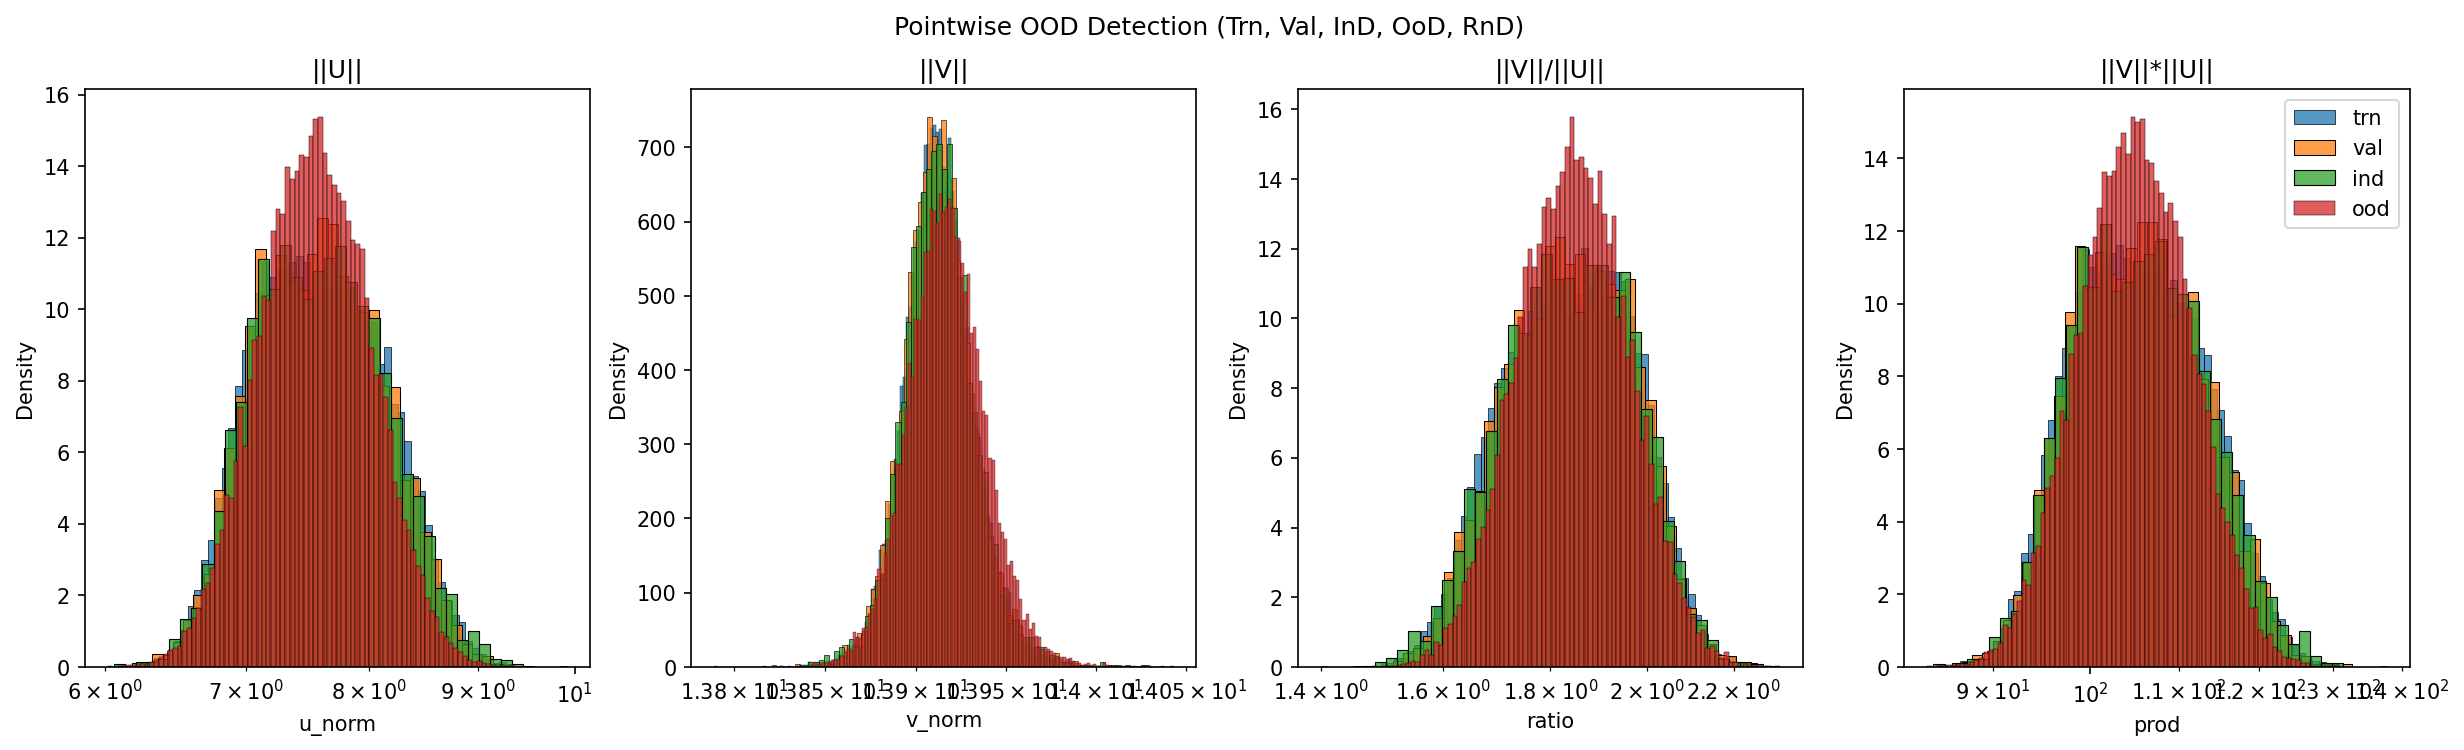

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 13.825778 14.027262 0.20148373
Val 13.820705 14.029352 0.20864677
Ind 13.840811 14.027977 0.18716621
Ood 13.78906 14.043088 0.25402832
Rnd 26.023802 31.294464 5.2706623
KstestResult(statistic=0.09794883899844642, pvalue=8.984129409629912e-38, statistic_location=13.922581, statistic_sign=1)


[2, 1, 0, 4, 3, 5, 9, 6, 7, 8]


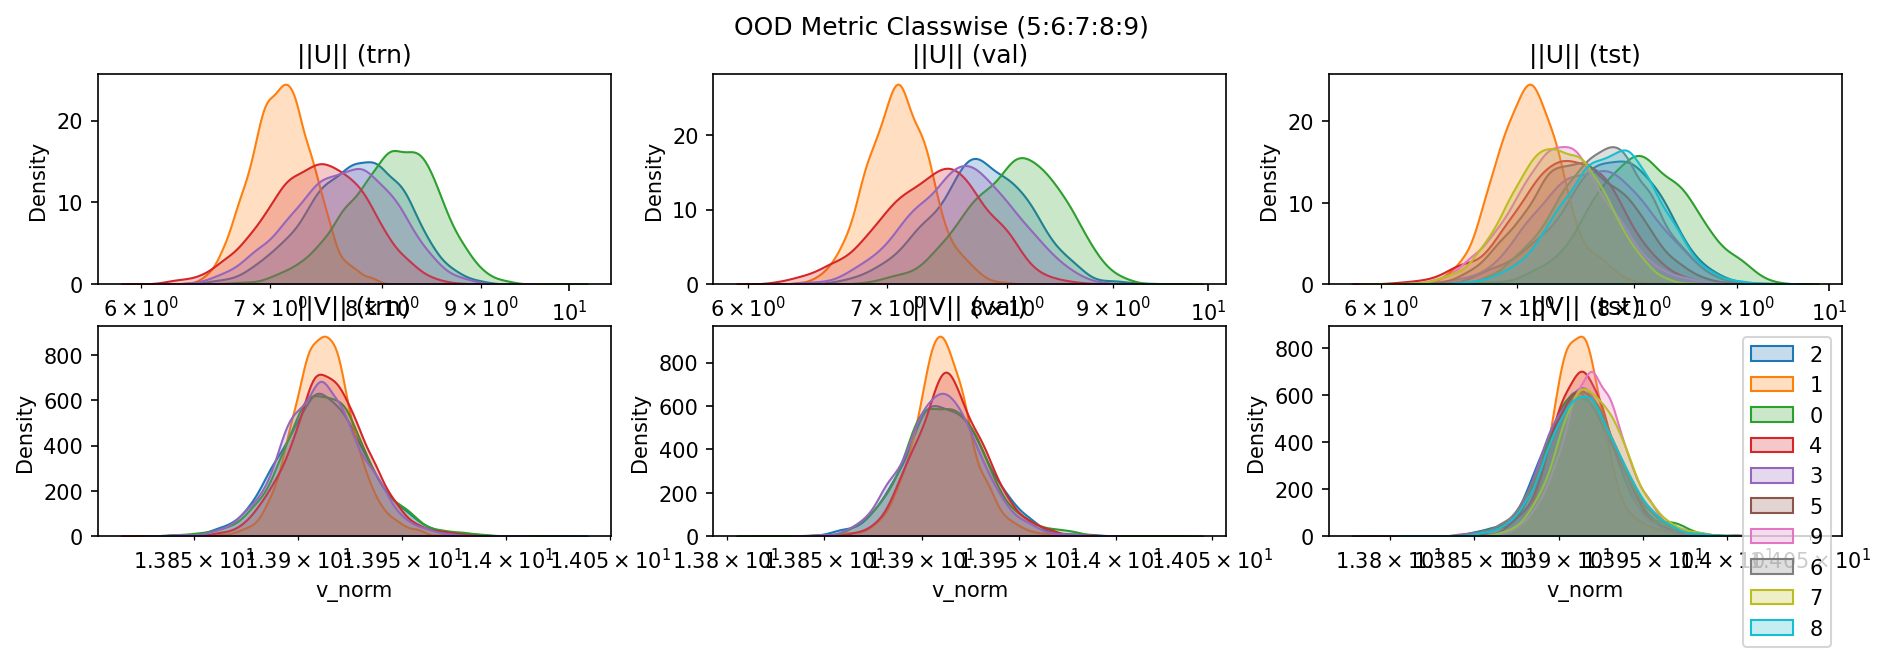

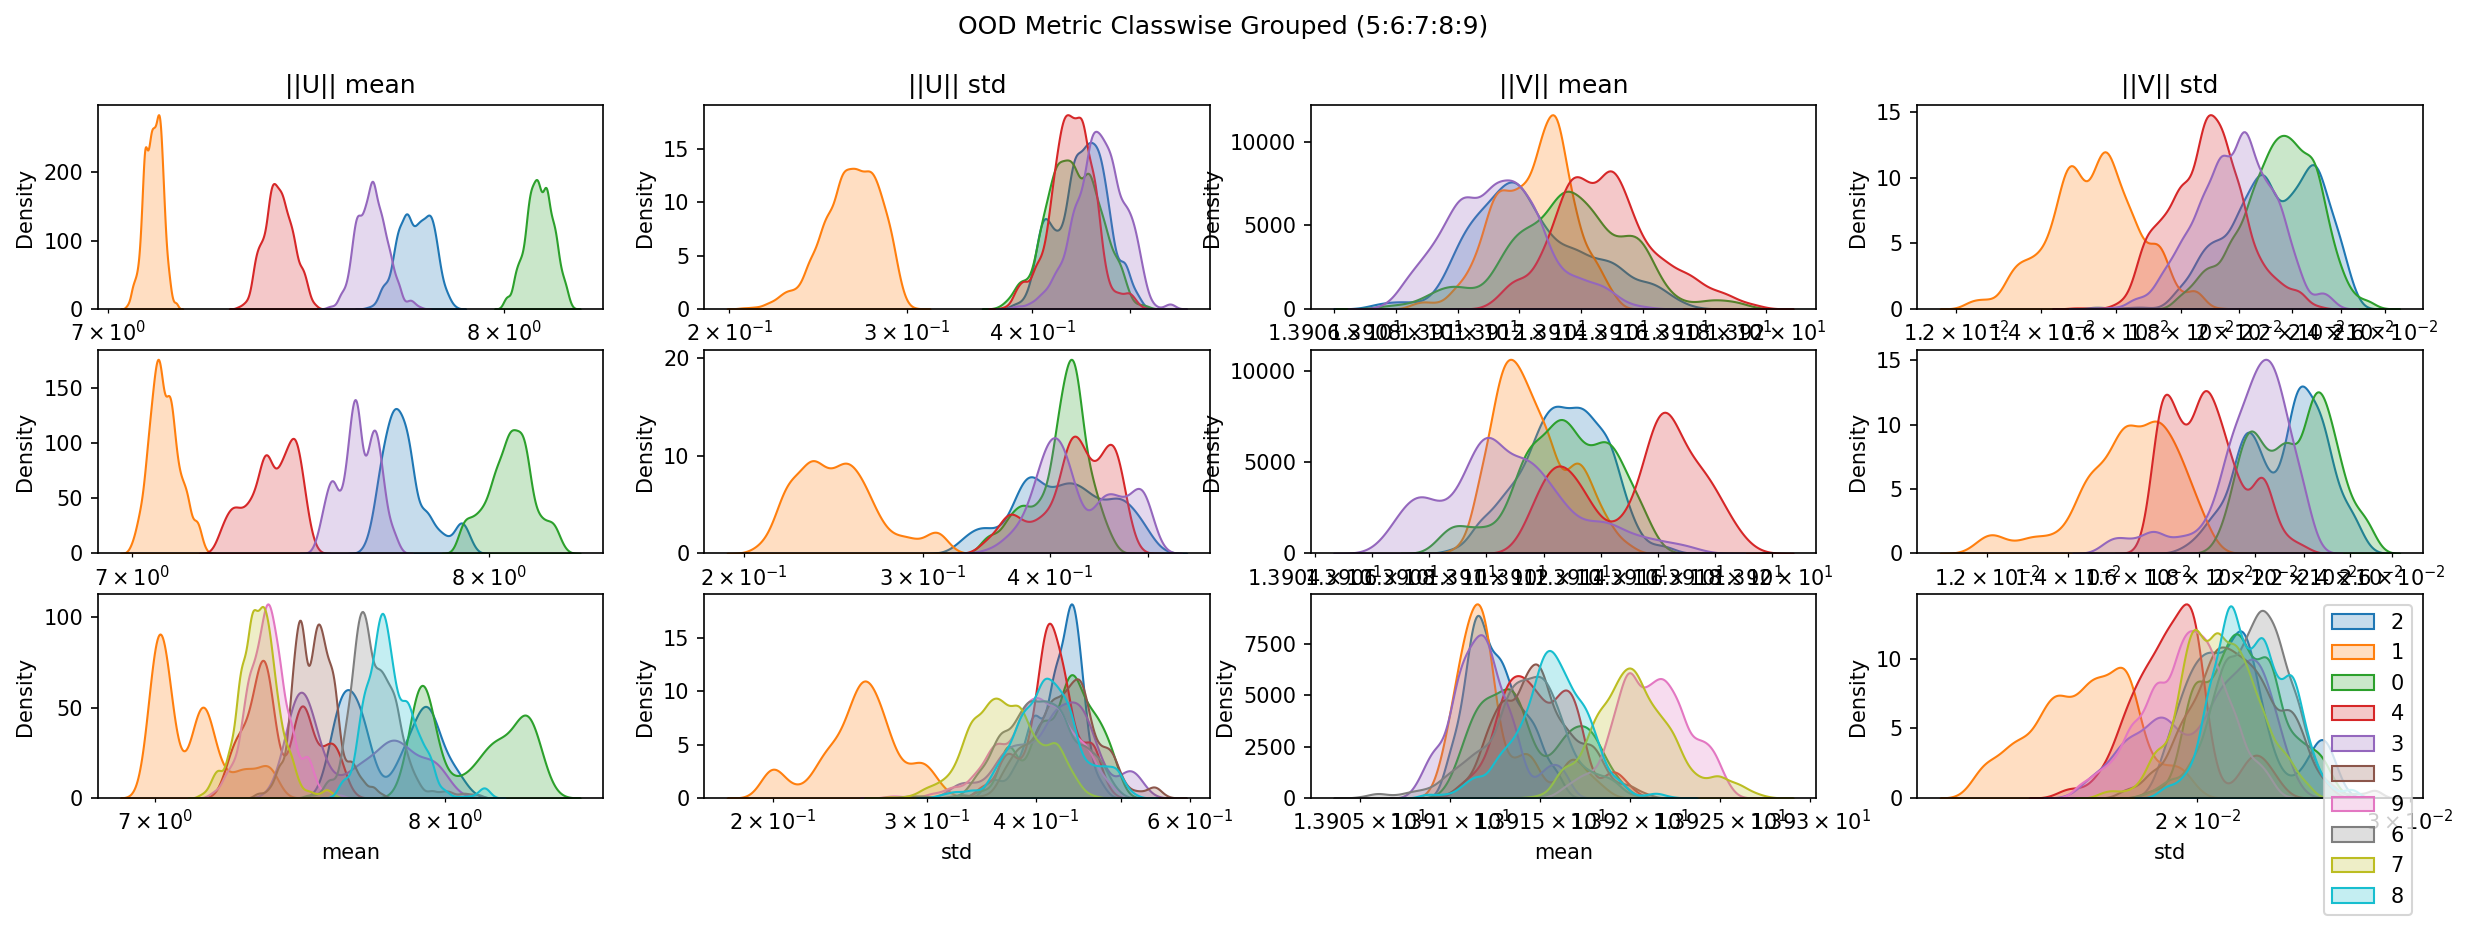

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
all_targets = list(data_tst['target'].unique())
print(all_targets)

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in all_targets:
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in all_targets:
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in all_targets:
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)